# Example: Neural Networks Sampling

Before runnning this notebook, make sure that all neccesary libraries are installed:

In [26]:
using Flux
using Random
using Gogeta
using Gurobi
using JuMP
using QuasiMonteCarlo
using Plots
using LaTeXStrings

## Initialize Neural Network with random weights

This time we are innitializing a simple neural network, that inputs 10d vector and outputs 1d number.

In [15]:
dimension = 10

begin
    Random.seed!(1234);

    NN_model = Chain(
        Dense(dimension => 100, relu),
        Dense(100 => 1)
    )
end

Chain(
  Dense(10 => 100, relu),               # 1_100 parameters
  Dense(100 => 1),                      # 101 parameters
)                   # Total: 4 arrays, 1_201 parameters, 4.941 KiB.

The input of the model is $x$, where $x_i\in[0,1]$ for $i=1,2,\dots,10$

In [16]:
# Set upper and lower input bounds for each variable
init_U = ones(dimension);
init_L = zeros(dimension);

Now, we can formulate NN as jump model with fast bound tightening, as explained in the example related to neural networks. See [`neural_networks.ipynb`](https://github.com/kankeinai/Gogeta.jl/blob/main/examples/neural_networks.ipynb)

In [18]:
# Formulate the MIP with heuristic bound tightening
jump_model = Model(Gurobi.Optimizer)
set_silent(jump_model)
NN_formulate!(jump_model, NN_model, init_U, init_L; bound_tightening="fast");

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20


Extracting the variable related to output neuron is exactly the same as in the previous example. Set objective to maximization of output neuron.

In [19]:
output_neuron = jump_model[:x][maximum(keys(jump_model[:x].data))]
@objective(jump_model, Max, output_neuron)

x[2,1]

With `QuasiMonteCarlo`, we generate 1000 random input samples. To generate sample we use `LatinHypercubeSample()`, which will generate us data that has space-filling properties and it converges faster. 

In [20]:
samples = QuasiMonteCarlo.sample(1000, init_L, init_U, LatinHypercubeSample());

For visual purposes, we can display first 2 dimensions of the dataset:

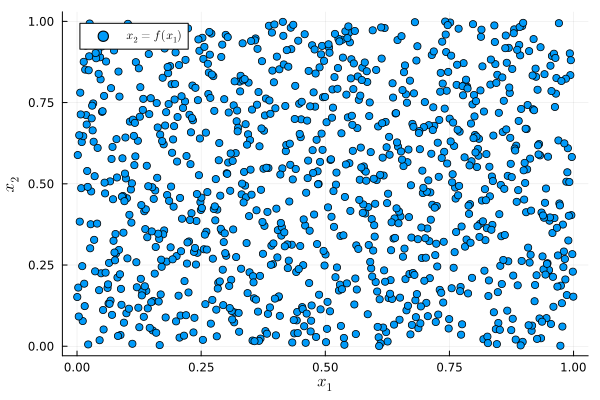

In [34]:
scatter(samples[1, :], samples[2, :], xlabel=L"x_1", ylabel=L"x_2", label=L"x_2 = f(x_1)")

And by calling out `optimize_by_sampling!()` function, we can find the optimal input that maximizes the output neuron. To understand the methodology behind this method see Perakis et al. (2022). Optimization by sampling can be benificial when the problem is large and instead of searching for solution in the whole space, we can concentrate on this samples. 

In [14]:
@time x_opt, optimum = optimize_by_sampling!(jump_model, samples);

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

`x_opt` is a vector that maximizes the objective function of our MIP formulation

In [34]:
x_opt

10-element Vector{Float64}:
 1.0
 0.0
 1.0
 0.6714514473214798
 0.9471119294402144
 1.0
 0.0
 0.0
 0.0
 0.0

In [39]:
optimum

0.07902304865851326

Since we assume that formualtion with fast bound tightening produces the same output as the NN, this vector should also maximize the NN

In [35]:
NN_model(Float32.(x_opt))[] ≈ optimum

true

Indeed the output of NN and our formulation are approximately the same.

We can optimize our MIP model directly by calling `optimize!(jump_model)`, but this approach is slower

In [36]:
@time optimize!(jump_model)

  9.164031 seconds (189.04 k allocations: 5.769 MiB)


and the objective value is approximately the same

In [40]:
objective_value(jump_model) ≈ optimum

true